# Actor Criticを実装する

In [51]:
from pathlib import Path
import math
import numpy as np
import pandas as pd
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import seaborn as sns
import settings

In [2]:
%load_ext autoreload
%autoreload 2

## パラメターの設定

In [4]:
model_dir_path = Path('mdoel')
result_dir_path = Path('result')
if not model_dir_path.exists():
    model_dir_path.mkdir()
if not result_dir_path.exists():
    result_dir_path.mkdir()

## モデルの構築

In [5]:
class Policy(nn.Module):

    def __init__(self):
        super(Policy, self).__init__()
        
        self.affine = nn.Linear(4, 128)

        self.action_head = nn.Linear(128, 2)
        self.value_head = nn.Linear(128, 1)

        self.saved_actions = []
        self.saved_rewards = []

    def forward(self, x):
        
        x = F.relu(self.affine(x))

        action_prob = F.softmax(self.action_head(x), dim=-1)
        state_values = self.value_head(x)

        return action_prob, state_values

In [31]:
def select_action(model, state, device):

    state = torch.from_numpy(state).float()
    probs, state_value = model(state.to(device))

    m = Categorical(probs)
    action = m.sample()
    model.saved_actions.append((m.log_prob(action), state_value))

    return action.item(), state_value

In [19]:
def learn_model(model, gamma, optimizer, device):

    R = 0
    returns = []
    for r in model.saved_rewards[::-1]:
        R = r + gamma * R
        returns.insert(0, R)

    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + 1e-06)

    policy_losses = []
    value_losses = []
    for (log_prob, value), R in zip(model.saved_actions, returns):
        advantage = R - value.item()
        policy_losses.append(-log_prob * advantage)
        value_losses.append(F.smooth_l1_loss(value, torch.tensor([R]).to(device)))

    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()
     
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    del model.saved_rewards[:]
    del model.saved_actions[:]

    return loss

## モデルの学習

In [8]:
env = gym.make('CartPole-v1')
env.seed(settings.seed)
torch.manual_seed(settings.seed)

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [55]:
model = Policy()
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-2)
eps = np.finfo(np.float32).eps.item()

reward_result = []
reward_displays = []
loss_result = []
loss_display = []
for episode in range(1, settings.epochs + 1):

    state = env.reset()
    episode_reward = 0
    for t in range(1, 10000):

        action, _ = select_action(model=model, state=state, device=device)
        state, reward, done, _ = env.step(action)

        if settings.flag_env_render:
            env.render()

        model.saved_rewards.append(reward)
        episode_reward += reward
        if done:
            break

    reward_displays.append(episode_reward)

    loss = learn_model(model=model, gamma=settings.gamma, optimizer=optimizer, device=device)
    loss = loss.detach().item()
    loss_display.append(loss)

    reward_result.append(episode_reward)
    loss_result.append(loss)

    if env.spec.max_episode_steps == np.mean(reward_displays):
        print('Game Win !!')
        break

    if episode % settings.display_loop == 0:
        print('Episode {}\tMean Loss: {:.2f}\tMean Reward: {:.0f}'.format(episode, np.mean(loss_display), np.mean(reward_displays)))
        reward_displays = []
        loss_display = []


model = model.to('cpu')
torch.save(model.state_dict(), model_dir_path.joinpath('actor_critic.pth'))

result = pd.DataFrame({
    'episode': np.arange(1, len(reward_result) + 1),
    'reward': reward_result,
    'loss': loss_result
})
result.to_csv(result_dir_path.joinpath('actor_critic_cartpole_result.csv'), index=False)

Episode 10	Mean Loss: 4.43	Mean Reward: 12
Episode 20	Mean Loss: 0.74	Mean Reward: 10
Episode 30	Mean Loss: 2.95	Mean Reward: 15
Episode 40	Mean Loss: 27.89	Mean Reward: 58
Episode 50	Mean Loss: 18.53	Mean Reward: 99
Episode 60	Mean Loss: 47.73	Mean Reward: 87
Episode 70	Mean Loss: 6.54	Mean Reward: 26
Episode 80	Mean Loss: 12.19	Mean Reward: 44
Episode 90	Mean Loss: 10.66	Mean Reward: 93
Episode 100	Mean Loss: 15.51	Mean Reward: 101
Episode 110	Mean Loss: 13.82	Mean Reward: 96
Episode 120	Mean Loss: 2.19	Mean Reward: 121
Episode 130	Mean Loss: 0.56	Mean Reward: 110
Episode 140	Mean Loss: 5.16	Mean Reward: 138
Episode 150	Mean Loss: 10.57	Mean Reward: 189
Episode 160	Mean Loss: 52.63	Mean Reward: 180
Episode 170	Mean Loss: 11.05	Mean Reward: 99
Episode 180	Mean Loss: 18.49	Mean Reward: 78
Episode 190	Mean Loss: 11.94	Mean Reward: 36
Episode 200	Mean Loss: 6.47	Mean Reward: 25
Episode 210	Mean Loss: 7.26	Mean Reward: 40
Episode 220	Mean Loss: 15.36	Mean Reward: 61
Episode 230	Mean Loss:

## モデルの検証

### 学習時の報酬の推移

In [56]:
result_data = pd.read_csv(result_dir_path.joinpath('actor_critic_cartpole_result.csv'))

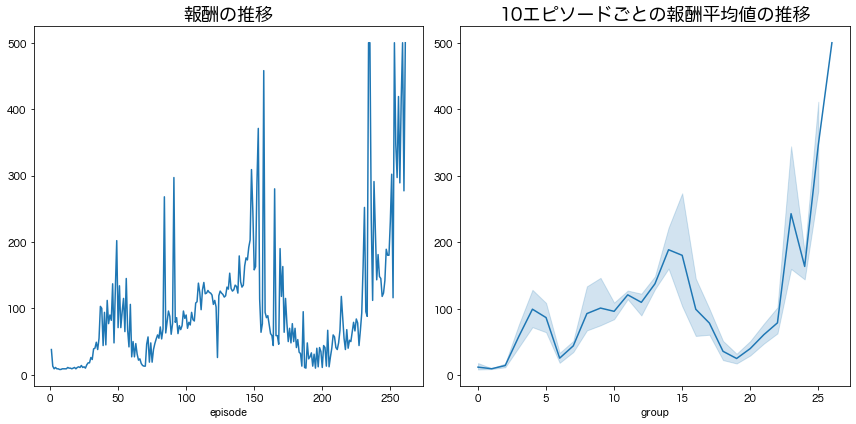

In [57]:
fig = plt.figure(figsize=(12, 6), facecolor='white')

ax = fig.add_subplot(1, 2, 1)
g = sns.lineplot(
    data=result_data,
    x='episode', y='reward',
    ax=ax
)
plt.title('報酬の推移', fontsize=18, weight='bold')
plt.ylabel('')

ax = fig.add_subplot(1, 2, 2)
g = sns.lineplot(
    data=result_data.assign(group=lambda x: x.episode.map(lambda y: math.floor((y - 1) / 10))),
    x='group', y='reward',
    ax=ax
)
plt.title('10エピソードごとの報酬平均値の推移', fontsize=18, weight='bold')
plt.ylabel('')

plt.tight_layout()
plt.savefig(result_dir_path.joinpath('actor_critic_cartpolcar_learning_reward.png'), dpi=300)

### 学習済みモデルの獲得報酬の分布

In [58]:
model = Policy()
model.load_state_dict(torch.load(model_dir_path.joinpath('actor_critic.pth')))
model.eval()

Policy(
  (affine): Linear(in_features=4, out_features=128, bias=True)
  (action_head): Linear(in_features=128, out_features=2, bias=True)
  (value_head): Linear(in_features=128, out_features=1, bias=True)
)

In [59]:
def select_action_valid(model, state, device):

    with torch.no_grad():
        state = torch.from_numpy(state).float()
        probs, state_value = model(state.to(device))

    return probs.argmax().item(), state_value

In [66]:
state = env.reset()
episode_reward = 0
done = False
while not done:

    action, state_value = select_action_valid(model=model, state=state, device=device)
    state, reward, done, _ = env.step(action)

    env.render()
    episode_reward += reward

print('Game End Reward: {:.0f}'.format(episode_reward))

Game End Reward: 500
